In [4]:
warnings = 0
library(ggplot2)
library(gplots)
library(ggfortify)
require(lmtest) 

The raw data was cleaned and filtered before the analysis. Only the complite data are kept.

The raw data is available at https://www.ebi.ac.uk/arrayexpress/experiments/E-GEOD-10718/

Load in the processed data

In [1]:
data = read.table('~/Dropbox/career_plan/data_scientist/transcription_cleaned.txt', header=TRUE,sep= "\t")
data.t = t(data[,2:ncol(data)])

colnames(data.t) = data$ID

This data contains the expression level for 11167 genes in normal human bronchial epithelial (NHBE) cells in 24 independent experiments.

"Experiment Overall Design: Cells were exposed to smoke or air (“mock-exposed”) for 15 min, after which they were refed with fresh media and allowed to incubate for 1h, 2h, 4h or 24h. Smoke and mock samples were compared at each time point."

For each time point, there are three replicates. 

In [11]:
str(data)

'data.frame':	11167 obs. of  25 variables:
 $ ID            : Factor w/ 11167 levels "1007_s_at","121_at",..: 11141 11142 11140 11144 11143 11146 11145 11148 11147 11160 ...
 $ Smoke.24h.repB: num  519 1002 523 1646 2018 ...
 $ Mock.1h.repB  : num  544 817 532 1468 1860 ...
 $ Mock.4h.repB  : num  558 796 536 1415 1834 ...
 $ Mock.2h.repA  : num  758 1023 682 1744 2446 ...
 $ Mock.2h.repC  : num  707 1086 659 1805 2404 ...
 $ Smoke.2h.repA : num  587 775 485 1546 1874 ...
 $ Mock.4h.repA  : num  500 613 448 1224 1628 ...
 $ Mock.24h.repC : num  524 842 531 1473 1937 ...
 $ Smoke.2h.repB : num  586 846 488 1527 2056 ...
 $ Smoke.1h.repA : num  2846 4417 2495 6498 8817 ...
 $ Smoke.24h.repC: num  547 829 540 1489 1684 ...
 $ Mock.1h.repA  : num  630 941 533 1526 2009 ...
 $ Smoke.24h.repA: num  603 802 512 1552 1898 ...
 $ Smoke.2h.repC : num  661 824 536 1660 2214 ...
 $ Mock.24h.repB : num  657 966 636 1699 2164 ...
 $ Mock.24h.repA : num  682 957 608 1832 2359 ...
 $ Smoke.1h.repC : n

perform the PCA analysis

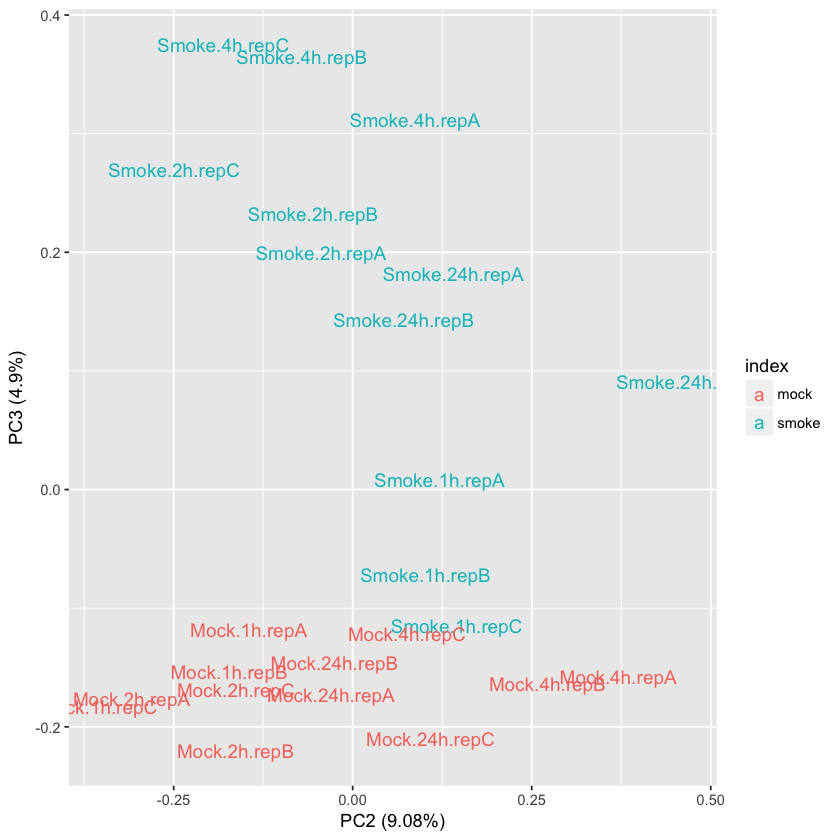

In [5]:
index = c("smoke","mock","mock","mock","mock","smoke","mock","mock","smoke","smoke","smoke","mock","smoke","smoke","mock","mock","smoke","mock","mock","mock","smoke","smoke","smoke","smoke")

df.index = data.frame(index = index)
data.t.new = cbind(data.t, df.index)

pca = prcomp(data.t.new[,1:11167])
autoplot(pca, x = 2, y = 3, colour = 'index', data=data.t.new,
         label = TRUE, label.size = 4, shape = FALSE)


Each gene was fit by linear regression to a full model where the timepoint, exposed to smoke or not, the interaction between the timepoint and smoke exposion were taken into account. An alternative reduced model where the smoking (as well as the smoking and time interaction) were ignored was also applied to the data of each gene. Likelihood ratio test was used to compare the two models. The genes whose expression level are highly dependent (FDR<0.001) on exposure of smoke are selected out based on the result of the likelihood ratio test.

Model:
expression level of gene =  timepoint + smoke exposure + timepoint * smoke exposure + error

Full model:
$$Y_{ijkl} = U_i + T_j + S_k + T_j * S_k + \epsilon_{ijkl}$$

Reduced model:
$$Y_{ijkl} = U_i + T_j + \epsilon_{ijkl}$$

$Y$ is the expression level

$U$ is the baseline expression level of gene $i$

$T$ is the timepoint $j$

$\epsilon$ is the error term, which can reflect the variance between replicates

In [8]:
#mock = 0 and smoke =1
indicator = c(1,0,0,0,0,1,0,0,1,1,1,0,1,1,0,0,1,0,0,0,1,1,1,1)
time = c(24,1,4,2,2,2,4,24,2,1,24,1,24,2,24,24,1,2,1,4,4,4,4,1)

df.add = data.frame(indicator = indicator, time = time)
data.reg = cbind(data.t.new, df.add)


In [ ]:
pvalue = c()

for (i in 1: nrow(data)){
  print(i)
  full = lm(data = data.reg, data.reg[,i] ~ time+indicator+time*indicator)
  reduce = lm(data = data.reg, data.reg[,i] ~ time)
  lr = lrtest(full, reduce)
  pvalue[i] = lr$`Pr(>Chisq)`[2]
}


As it takes a while to calculate the pvalue for all the likelihood ratio test, I calculated in R and will just load it to the notebook here. 

In [6]:
load(file='~/Dropbox/career_plan/data_scientist/pvalue.Rdata')

In [9]:
fdr = p.adjust(pvalue, method='fdr')
significant.idx = which(fdr<0.001)
data.plot = as.matrix(data.reg[,significant.idx])
data.plot.scale = t(scale(data.plot))


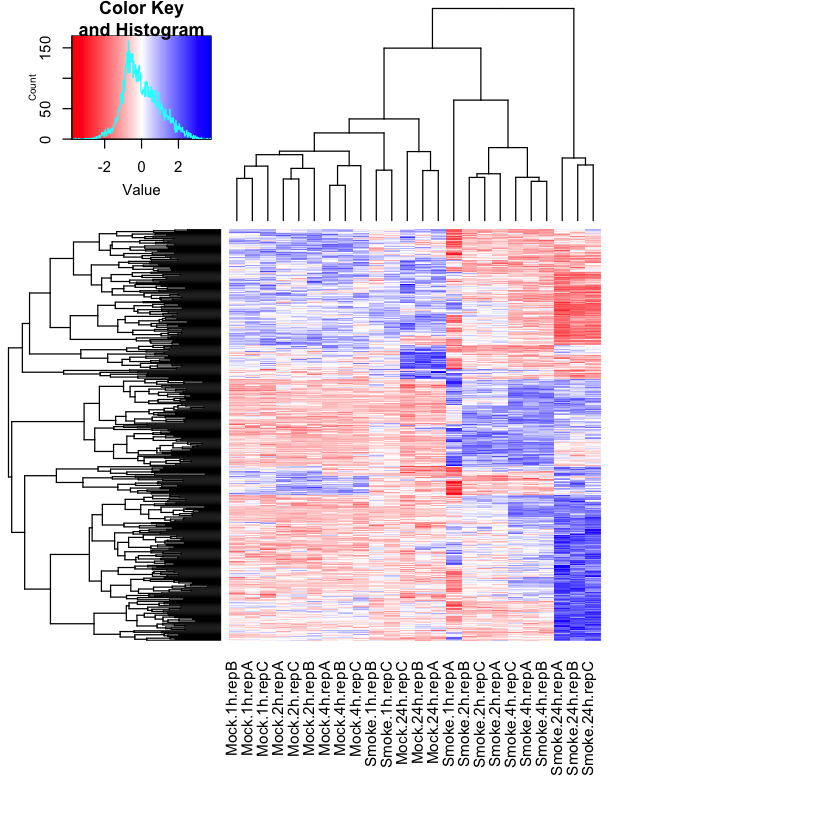

In [10]:
my_palette <- colorRampPalette(c("red", "white", "blue"))(n = 299)
par(mar=c(1,1,1,1))
heatmap.2(data.plot.scale, trace='none',
          margins=c(10,12), col = my_palette,
          labRow = FALSE)